In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns


In [2]:
%cd /content/drive/MyDrive/Documents/Code/Datasets/Golf/LaunchMonitorData

/content/drive/MyDrive/Documents/Code/Datasets/Golf/LaunchMonitorData


In [3]:
# prompt: load all files into dfs from the current folder and combine into single clean, formatted dataframe

import pandas as pd, numpy as np
import glob

# Get a list of all CSV files in the current directory
all_files = glob.glob("*.csv")

# Create an empty list to store dataframes
li = []

# Loop through the files and read each into a dataframe
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

# Concatenate all dataframes into a single dataframe
frame = pd.concat(li, axis=0, ignore_index=True)



## Clean dataframe and group by club


In [4]:

# Basic cleaning and formatting (example - customize based on your data)
# Remove any columns with missing values missing
frame.dropna(axis=1,how='all',inplace=True)

# Convert relevant columns to appropriate data types (e.g., numeric, datetime)
# Example: assuming 'some_column' should be numeric
frame['Shot Created Date'] = pd.to_datetime(frame['Shot Created Date'])

# Drop empty columns and shots with clubs that arent in bag anymore (5w-4&5h, 3i-4i)
cols = frame.columns[-11:]
frame.drop(cols, axis=1, inplace=True)
frame = frame[frame['Club Name'] != '4i']
frame = frame[frame['Club Name'] != '3i']
frame = frame[frame['Club Name'] != '5h']
frame = frame[frame['Club Name'] != '4h']
frame = frame[frame['Club Name'] != '5w']

# Reset index after cleaning
frame.reset_index(drop=True, inplace=True)


#create function to drop outliers using z-score
def drop_outliers(df, col, threshold=3):
  """
  Drops outliers from a specified column in a DataFrame using Z-score.

  Args:
      df (pd.DataFrame): The input DataFrame.
      col (str): The name of the column to check for outliers.
      threshold (int, optional): The Z-score threshold to identify outliers.
                                 Defaults to 3.

  Returns:
      pd.DataFrame: The DataFrame with outliers removed for the specified column.
  """
  if col not in df.columns:
    print(f"Warning: Column '{col}' not found in DataFrame.")
    return df

  # Calculate Z-scores
  z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())

  # Filter out rows where the Z-score is above the threshold
  df_cleaned = df[z_scores < threshold].copy()
  return df_cleaned

# Display the first few rows of the combined dataframe
print(frame.head())
print(frame.info())

# Group by 'Club Name' and apply the outlier removal function
grouped_data = frame.groupby('Club Name').apply(lambda x: drop_outliers(x, 'Total Distance (yds)'))

# Reset the index of the grouped data to turn it back into a single DataFrame
# and maintain the original index structure or create a new one.
grouped_data = grouped_data.reset_index(drop=True)

print("\nDataFrame after dropping outliers per club:")
print(grouped_data.head())
print(grouped_data.info())

   Shot Number Club Name Club Type   Shot Created Date  Ball Speed (mph)  \
0            1        LW     Wedge 2025-04-21 03:19:59              55.9   
1            2        LW     Wedge 2025-04-21 03:20:29              49.2   
2            3        LW     Wedge 2025-04-21 03:20:54              53.7   
3            4        LW     Wedge 2025-04-21 03:21:06              55.9   
4            5        LW     Wedge 2025-04-21 03:21:22              58.2   

   Push/Pull (deg L-/R+)  Launch Angle (deg)  Back Spin (rpm)  \
0                    4.2                42.7             7823   
1                    4.9                43.0             6672   
2                    2.7                41.9             5844   
3                   -3.0                38.3             7580   
4                    1.8                39.4             7257   

   Side Spin (rpm L-/R+)  Total Spin (rpm)  Carry (yds)  Total Distance (yds)  \
0                   -644              7849         52.0                

<ipython-input-4-2663926040>:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_data = frame.groupby('Club Name').apply(lambda x: drop_outliers(x, 'Total Distance (yds)'))


# Combine all CSV files into a single DataFrame

In [5]:
"""import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load all CSVs from sessions folder
directory_path = '/content/drive/MyDrive/Documents/Code/Datasets/Golf/LaunchMonitorData'
dataframes = []

for filename in os.listdir(directory_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory_path, filename)
        dataframes.append(pd.read_csv(file_path))

# Step 2: Combine all files
combined_df = pd.concat(dataframes, ignore_index=True)

# Step 3: Normalize and optimize club names
combined_df['Club Name'] = combined_df['Club Name'].astype(str).str.strip().str.lower()

club_name_map = {
    'driver': 'Dr', 'dr': 'Dr',
    '3 wood': '3w', '3w': '3w',
    '5 wood': '5w', '5w': '5w',
    '3 hybrid': '3h', '3h': '3h',
    '4 hybrid': '4h', '4h': '4h',
    '3 iron': '3i', '3i': '3i',
    '4 iron': '4i', '4i': '4i',
    '5 iron': '5i', '5i': '5i',
    '6 iron': '6i', '6i': '6i',
    '7 iron': '7i', '7i': '7i',
    '8 iron': '8i', '8i': '8i',
    '9 iron': '9i', '9i': '9i',
    'pitching wedge': 'PW', 'pw': 'PW',
    'gap wedge': 'GW', 'gw': 'GW',
    'sand wedge': 'SW', 'sw': 'SW',
    'lob wedge': 'LW', 'lw': 'LW',
    'wedge': 'SW', 'swedge': 'SW'  # catch-all for generic "wedge"
}
combined_df['Club Name'] = combined_df['Club Name'].map(club_name_map).fillna('Other')

# Step 4: Filter to valid club list only
valid_clubs = ['Dr', '3w', '3h', '5i', '6i', '7i', '8i', '9i', 'PW', 'GW', 'SW', 'LW']
combined_df = combined_df[combined_df['Club Name'].isin(valid_clubs)]

# Step 5: Violin plot of carry distance by club
plt.figure(figsize=(14, 6))
sns.violinplot(
    data=combined_df,
    x='Club Name',
    y='Carry (yds)',
    order=valid_clubs,
    palette='tab20',
    inner='box'
)
plt.xticks(rotation=45)
plt.title='Carry Distance Distribution by Club'
plt.tight_layout()
plt.show()
combined_df.to_csv('all_shots_gulftee.csv')
"""

'import os\nimport pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Step 1: Load all CSVs from sessions folder\ndirectory_path = \'/content/drive/MyDrive/Documents/Code/Datasets/Golf/LaunchMonitorData\'\ndataframes = []\n\nfor filename in os.listdir(directory_path):\n    if filename.endswith(".csv"):\n        file_path = os.path.join(directory_path, filename)\n        dataframes.append(pd.read_csv(file_path))\n\n# Step 2: Combine all files\ncombined_df = pd.concat(dataframes, ignore_index=True)\n\n# Step 3: Normalize and optimize club names\ncombined_df[\'Club Name\'] = combined_df[\'Club Name\'].astype(str).str.strip().str.lower()\n\nclub_name_map = {\n    \'driver\': \'Dr\', \'dr\': \'Dr\',\n    \'3 wood\': \'3w\', \'3w\': \'3w\',\n    \'5 wood\': \'5w\', \'5w\': \'5w\',\n    \'3 hybrid\': \'3h\', \'3h\': \'3h\',\n    \'4 hybrid\': \'4h\', \'4h\': \'4h\',\n    \'3 iron\': \'3i\', \'3i\': \'3i\',\n    \'4 iron\': \'4i\', \'4i\': \'4i\',\n    \'5 iron\': \'5i\'

Filling in missing values in Club Speed (mph) and Club Speed at Impact Location (mph)

In [ ]:
club_lofts = {
    'Dr': 10.5,
    '3w': 15,
    '5w': 19,
    '3h': 19,
    '4h': 22,
    '5h': 25,
    '3i': 21,
    '4i': 24,
    '5i': 27,
    '6i': 31,
    '7i': 35,
    '8i': 39,
    '9i': 43,
    'PW': 47
}

# Function to get the loft for each club
def get_club_loft(club_name):
    return club_lofts.get(club_name, None)

# Apply the function to get the loft for each club
data['Loft (deg)'] = data['Club Name'].apply(get_club_loft)


# Estimate Club Speed (mph)
def estimate_club_speed(row):
    if pd.isnull(row['Club Speed (mph)']):
        if 'Driver' in row['Club Type']:
            return row['Ball Speed (mph)'] / 1.55 # Assuming average smash factor of 1.45 for driver
        elif 'Iron' in row['Club Type']:
            return row['Ball Speed (mph)']  / 1.25
        elif 'Hybrid' in row['Club Type']:
            return row['Ball Speed (mph)'] / 1.35
        elif 'FW' in row['Club Type']:
            return row['Ball Speed (mph)'] / 1.45

    return row['Club Speed (mph)']

# Estimate Club Speed at Impact Location (mph)
def estimate_club_speed_impact(row):
    if pd.isnull(row['Club Speed at Impact Location (mph)']):
        return row['Club Speed (mph)'] * 0.98  # Assuming a slight reduction for off-center hits
    return row['Club Speed at Impact Location (mph)']

# Calculate Efficiency
def calculate_efficiency(row):
    if pd.isnull(row['Efficiency']):
        if 'Driver' in row['Club Type']:
            return row['Efficiency'] / 1.55 # Assuming average smash factor of 1.45 for driver
        elif 'Iron' in row['Club Type']:
            return row['Efficiency']  / 1.25
        elif 'Hybrid' in row['Club Type']:
            return row['Efficiency'] / 1.35
        elif 'FW' in row['Club Type']:
            return row['Efficiency'] / 1.45

    return row['Efficiency']

# Estimate Angle of Attack (deg)
#def estimate_angle_of_attack(row):
#    if pd.isnull(row['Angle of Attack (deg)']):
#        if 'Driver' in row['Club Type']:
#            return row['Launch Angle (deg)'] - 12  # Adjust to fit the +1 to +5 range
#        elif 'Iron' in row['Club Type']:
#            return row['Launch Angle (deg)'] - 5  # Adjust to fit the -3 to -6 range
#        elif 'Hybrid' in row['Club Type']:
#            return row['Launch Angle (deg)'] - 5  # Adjust to fit the -2 to +2 range
#        elif 'FW' in row['Club Type']:
#            return row['Launch Angle (deg)'] - 7  # Adjust to fit the -1 to +3 range
#    return row['Angle of Attack (deg)']

# Estimate Club Path (deg out-in-/in-out+)
def estimate_club_path(row):
    if pd.isnull(row['Club Path (deg out-in-/in-out+)']):
        return row['Push/Pull (deg L-/R+)'] * 1.2  # Assuming a relationship between path and face angle
    return row['Club Path (deg out-in-/in-out+)']

# Estimate Face to Target (deg closed-/open+)
def estimate_face_to_target(row):
    if pd.isnull(row['Face to Target (deg closed-/open+)']):
        return row['Push/Pull (deg L-/R+)']
    return row['Face to Target (deg closed-/open+)']

# Estimate Lie (deg toe down-/toe up+)
def estimate_lie(row):
    if pd.isnull(row['Lie (deg toe down-/toe up+)']):
        return 0  # Default to 0 if no data available
    return row['Lie (deg toe down-/toe up+)']

# Loft (deg) is already present in the data

# Estimate Face Impact Horizontal (mm toe-/heel+)
def estimate_face_impact_horizontal(row):
    if pd.isnull(row['Face Impact Horizontal (mm toe-/heel+)']):
        return 0  # Default if no data available
    return row['Face Impact Horizontal (mm toe-/heel+)']

# Estimate Face Impact Vertical (mm low-/high+)
def estimate_face_impact_vertical(row):
    if pd.isnull(row['Face Impact Vertical (mm low-/high+)']):
        return 0  # Default if no data available
    return row['Face Impact Vertical (mm low-/high+)']

# Estimate Closure Rate (deg/sec)
def estimate_closure_rate(row):
    if pd.isnull(row['Closure Rate (deg/sec)']):
        return 0  # Default if no data available
    return row['Closure Rate (deg/sec)']

# Apply functions to calculate missing metrics
data['Club Speed (mph)'] = data.apply(estimate_club_speed, axis=1)
data['Club Speed at Impact Location (mph)'] = data.apply(estimate_club_speed_impact, axis=1)
data['Efficiency'] = data.apply(calculate_efficiency, axis=1)
#data['Angle of Attack (deg)'] = data.apply(estimate_angle_of_attack, axis=1)
data['Club Path (deg out-in-/in-out+)'] = data.apply(estimate_club_path, axis=1)
data['Face to Target (deg closed-/open+)'] = data.apply(estimate_face_to_target, axis=1)
data['Lie (deg toe down-/toe up+)'] = data.apply(estimate_lie, axis=1)
data['Face Impact Horizontal (mm toe-/heel+)'] = data.apply(estimate_face_impact_horizontal, axis=1)
data['Face Impact Vertical (mm low-/high+)'] = data.apply(estimate_face_impact_vertical, axis=1)
data['Closure Rate (deg/sec)'] = data.apply(estimate_closure_rate, axis=1)



<ipython-input-6-1193474781>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=frame,x='Club Type',y='Side Spin (rpm L-/R+)', palette='colorblind')


<Axes: xlabel='Club Type', ylabel='Side Spin (rpm L-/R+)'>

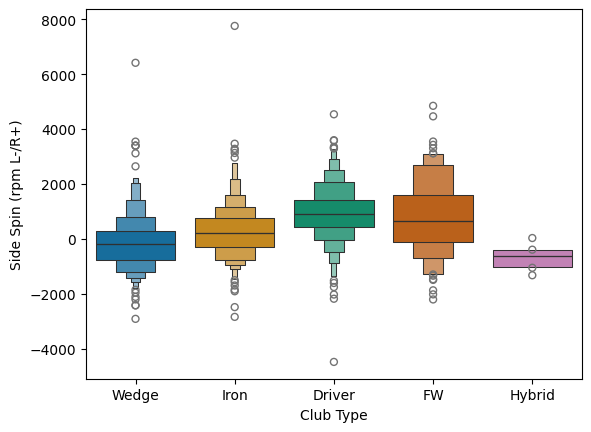

In [6]:
sns.boxenplot(data=frame,x='Club Type',y='Side Spin (rpm L-/R+)', palette='colorblind')

In [7]:
# prompt: sort "data" df by avg carry distance from largest to smallest
data = grouped_data.copy()
# Calculate average carry distance per club
avg_carry_distance = data.groupby('Club Name')['Carry (yds)'].mean().reset_index()

# Sort by average carry distance from largest to smallest
sorted_data = avg_carry_distance.sort_values(by='Carry (yds)', ascending=False)

sorted_data

,Club Name,Carry (yds)
7,Dr,197.163441
1,3w,178.928302
0,3h,150.337500
2,5i,146.043956
3,6i,143.468085
4,7i,128.036923
5,8i,127.191803
6,9i,109.265854
10,PW,93.946809
8,GW,80.926230


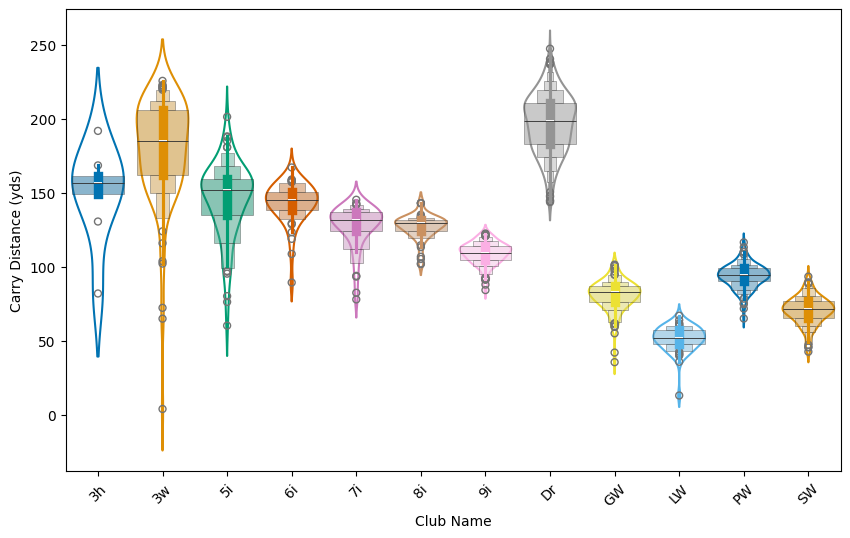

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize carry distance distribution
plt.figure(figsize=(10, 6))
sns.violinplot(x='Club Name', y='Carry (yds)', data=data, palette='colorblind',fill=False)
sns.boxenplot(x='Club Name', y='Carry (yds)', data=data, palette='colorblind', alpha=0.5, linewidth=0.5)
plt.title = 'Carry Distance Distribution by Club'
plt.xlabel('Club Name')
plt.ylabel('Carry Distance (yds)')
plt.xticks(rotation=45)
plt.show()


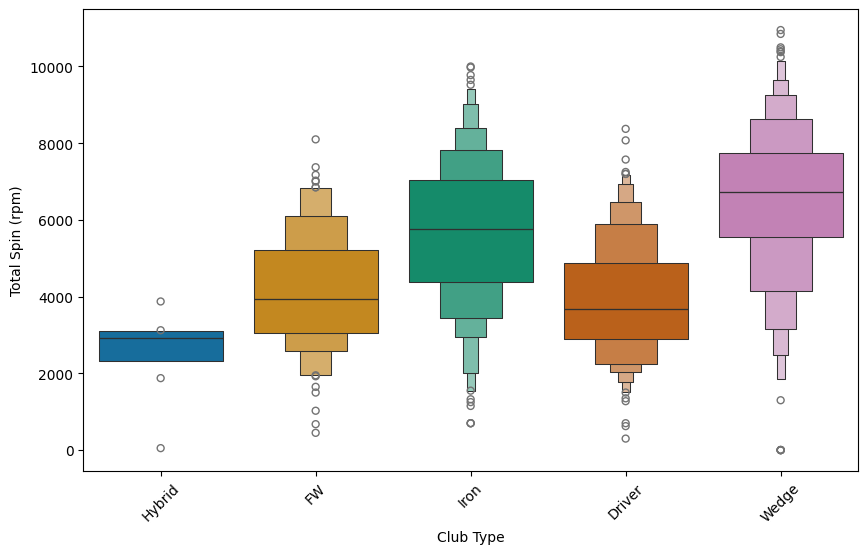

In [9]:
plt.figure(figsize=(10, 6))
sns.boxenplot(x='Club Type', y='Total Spin (rpm)', data=data, palette='colorblind', hue='Club Type',legend=False)
plt.title= ('Total Spin (rpm) Distribution by Club')
plt.xlabel('Club Type')
plt.ylabel('Total Spin (rpm)')
plt.xticks(rotation=45)
plt.show()

<ipython-input-10-75153360>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='Club Name', y='Push/Pull (deg L-/R+)', data=data, palette="colorblind")


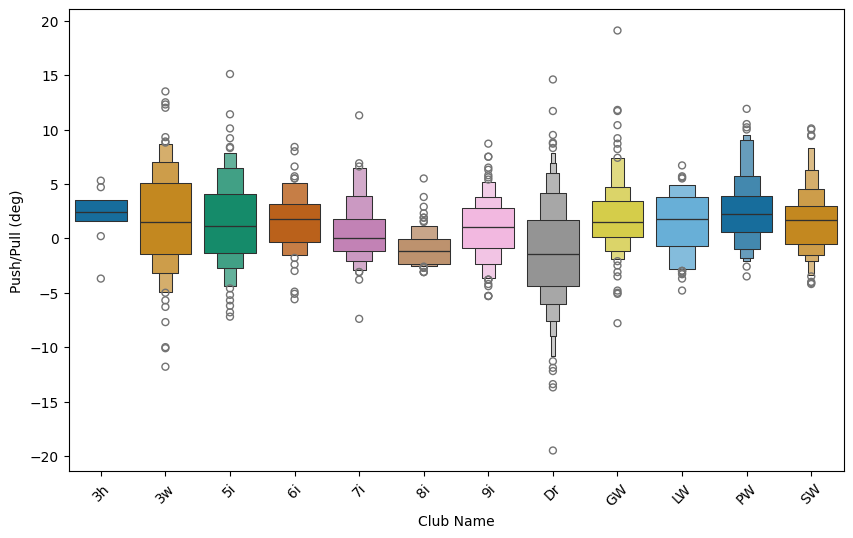

In [10]:
# Visualize accuracy (Push/Pull) distribution
plt.figure(figsize=(10, 6))
sns.boxenplot(x='Club Name', y='Push/Pull (deg L-/R+)', data=data, palette="colorblind")
plt.title = ('Push/Pull Distribution by Club')
plt.xlabel('Club Name')
plt.ylabel('Push/Pull (deg)')
plt.xticks(rotation=45)
plt.show()


Data sorted by Carry (yds):
     Club Name  Carry (yds)
86          3w          4.2
1020        LW         13.3
955         GW         35.8
1001        LW         36.1
1030        LW         40.2


<ipython-input-11-2084359845>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


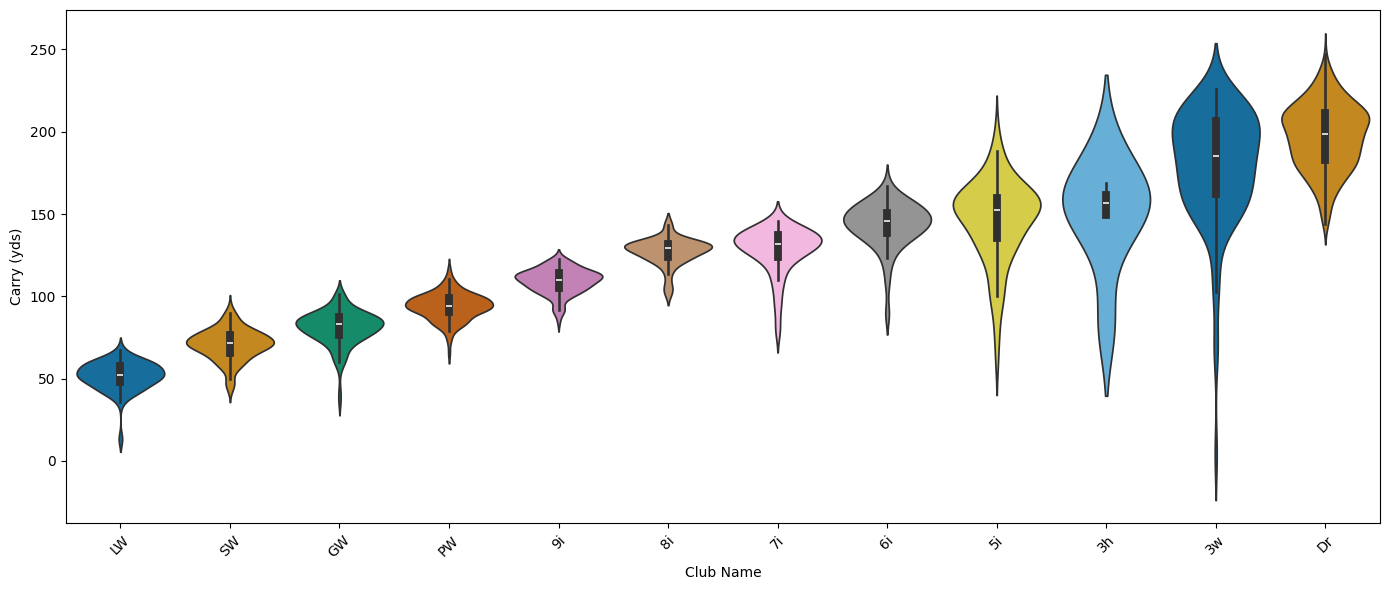

<ipython-input-11-2084359845>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(


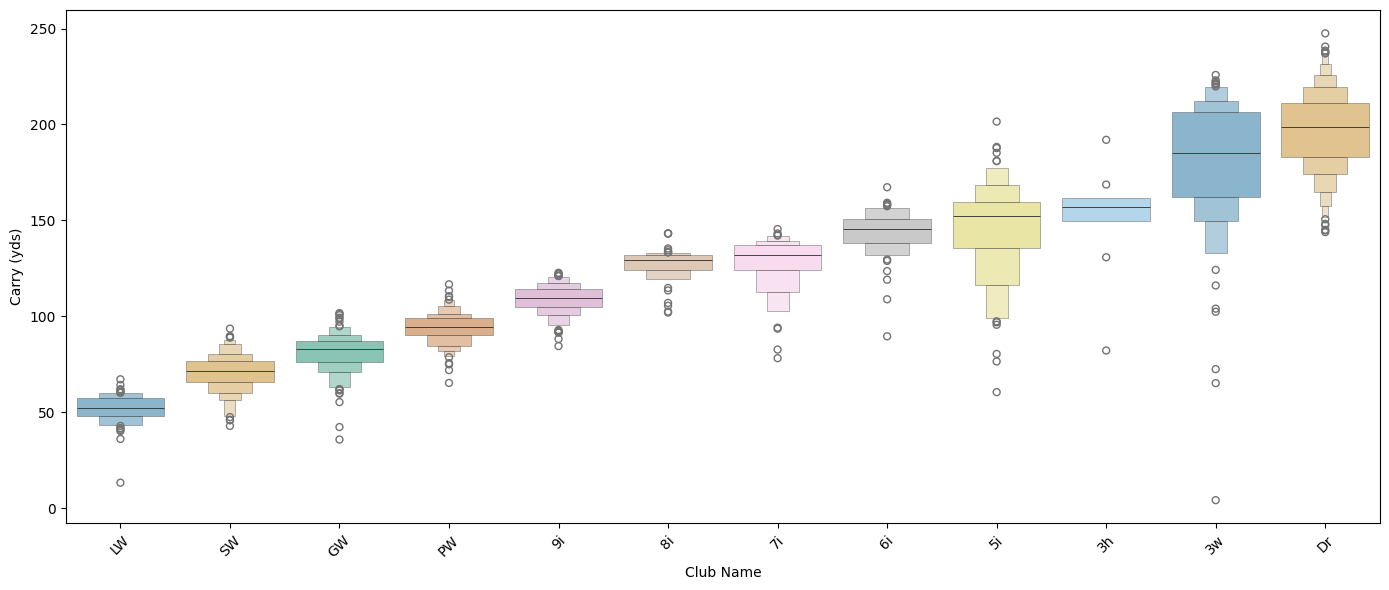

In [11]:
# prompt: sort the carry distances of the "data" df so when plotted, they are from smallest to largest

import matplotlib.pyplot as plt
# Sort the data by 'Carry (yds)' from smallest to largest
data_sorted_by_carry = data.sort_values(by='Carry (yds)', ascending=True)

print("Data sorted by Carry (yds):")
print(data_sorted_by_carry[['Club Name', 'Carry (yds)']].head()) # print the first few rows to verify sorting

# You can now use `data_sorted_by_carry` for plotting if you want the entire dataset sorted
# or just the `sorted_data` which has the average carry for plotting the order of clubs on the x-axis.

# To ensure the violin/boxen plots are sorted by average carry distance (smallest to largest):
# Get the order of clubs based on average carry distance (ascending)
avg_carry_distance_asc = data.groupby('Club Name')['Carry (yds)'].mean().sort_values(ascending=True).index.tolist()

# Violin plot sorted by average carry distance
plt.figure(figsize=(14, 6))
sns.violinplot(
    data=data,
    x='Club Name',
    y='Carry (yds)',
    order=avg_carry_distance_asc, # Use the ascending order
    palette='colorblind',
    inner='box'
)
plt.xticks(rotation=45)
plt.title='Carry Distance Distribution by Club (Sorted by Average Carry)'
plt.tight_layout()
plt.show()

# Boxen plot sorted by average carry distance
plt.figure(figsize=(14, 6))
sns.boxenplot(
    data=data,
    x='Club Name',
    y='Carry (yds)',
    order=avg_carry_distance_asc, # Use the ascending order
    palette='colorblind',
    alpha=0.5,
    linewidth=0.5
)
plt.xticks(rotation=45)
plt.title='Carry Distance Distribution by Club (Sorted by Average Carry)'
plt.tight_layout()
plt.show()

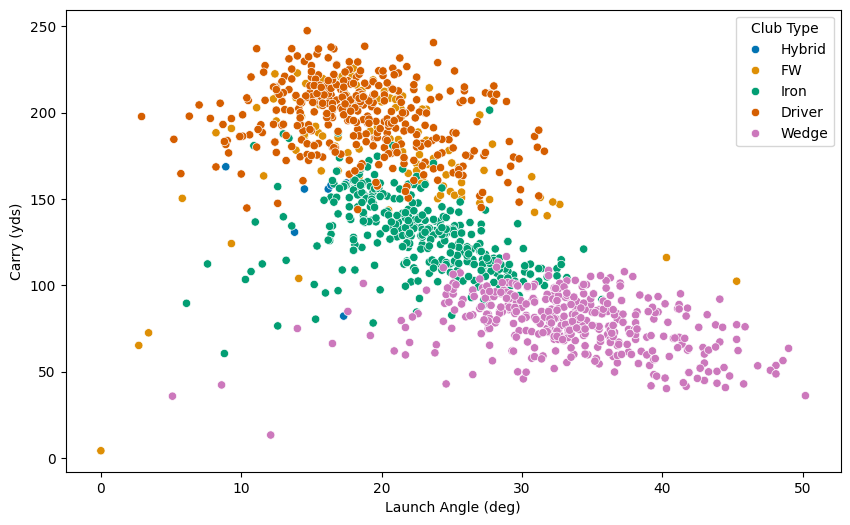

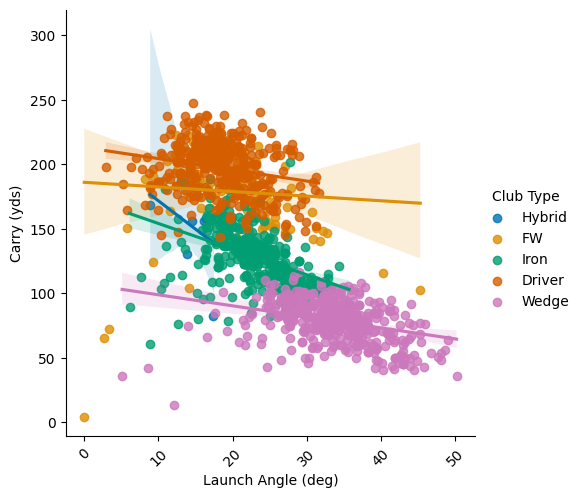

In [17]:
# Visualize launch angle and Carry
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Launch Angle (deg)', y='Carry (yds)',hue ='Club Type' ,data=data, palette='colorblind')
plt.title='Launch Angle and Carry relationship'
sns.lmplot(x='Launch Angle (deg)', y='Carry (yds)', data=data, hue= 'Club Type', palette='colorblind')
plt.xticks(rotation=45)
plt.show()


<ipython-input-20-1837489032>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(


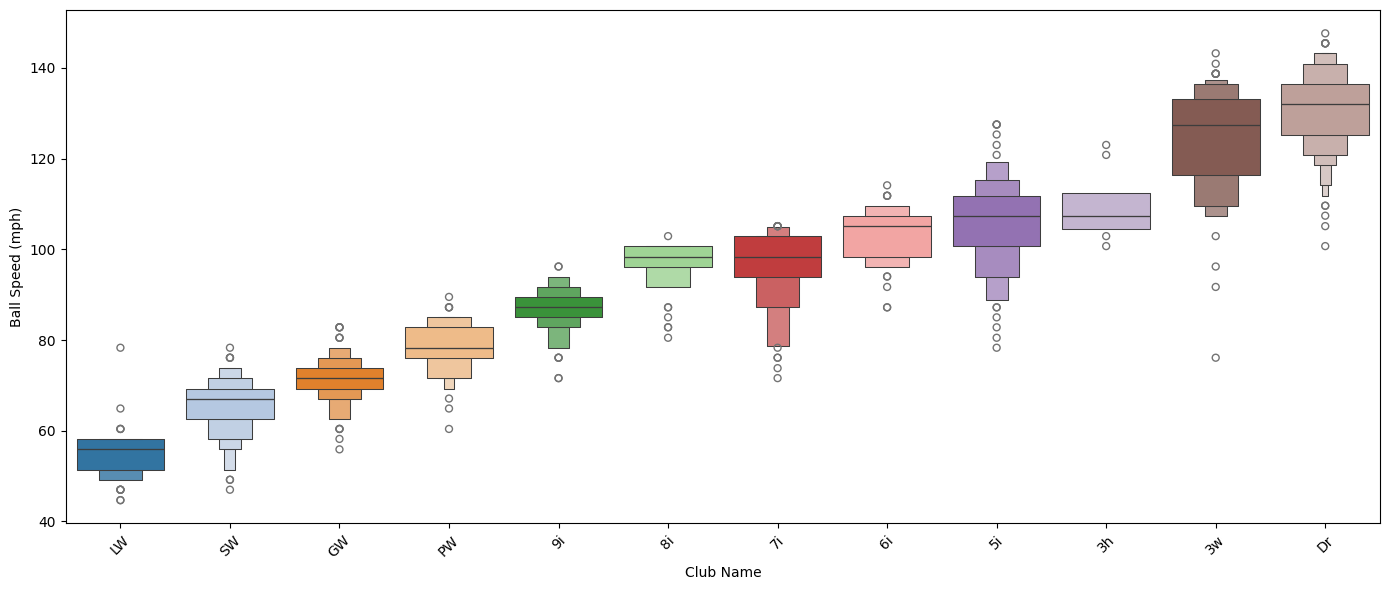

In [20]:
# prompt: sort the club avg distances from low to high then plot ball speed distribution by club boxenplots

import matplotlib.pyplot as plt
# Calculate average carry distance per club and sort
avg_carry_by_club = frame.groupby('Club Name')['Carry (yds)'].mean().sort_values()

# Get the sorted list of clubs
sorted_clubs = avg_carry_by_club.index.tolist()

# Plot Ball Speed distribution by club using boxenplots, sorted by average carry distance
plt.figure(figsize=(14, 6))
sns.boxenplot(
    data=frame,
    x='Club Name',
    y='Ball Speed (mph)',
    order=sorted_clubs,
    palette='tab20'
)
plt.xticks(rotation=45)
plt.title='Ball Speed Distribution by Club (Sorted by Average Carry Distance)'
plt.ylabel('Ball Speed (mph)')
plt.tight_layout()
plt.show()

<ipython-input-74-f875f941cc08>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Club Name', y='Ball Speed (mph)', data=data, palette='colorblind', alpha=0.5,order=sorted_clubs)
<ipython-input-74-f875f941cc08>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='Club Name', y='Ball Speed (mph)', data=data,  palette='colorblind', fill=False,order=sorted_clubs)


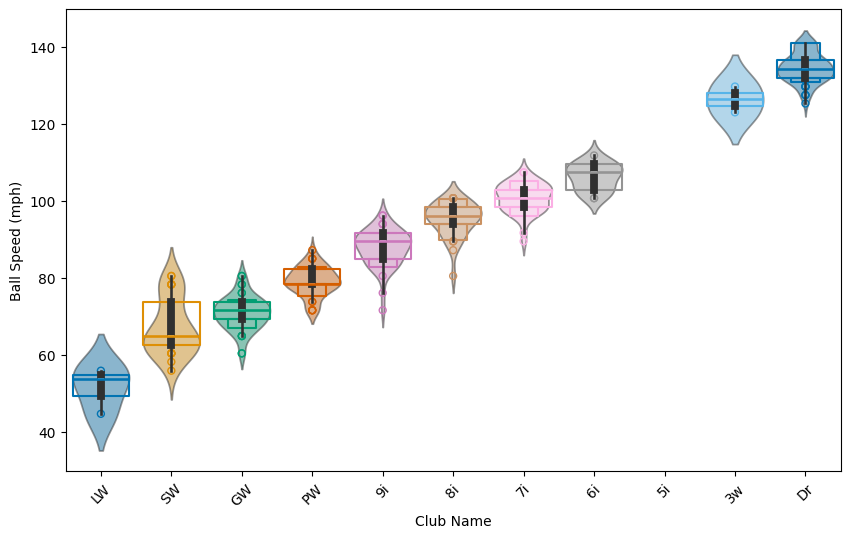

In [ ]:
# Visualize accuracy (Push/Pull) distribution
plt.figure(figsize=(10, 6))
sns.violinplot(x='Club Name', y='Ball Speed (mph)', data=data, palette='colorblind', alpha=0.5,order=sorted_clubs)
sns.boxenplot(x='Club Name', y='Ball Speed (mph)', data=data,  palette='colorblind', fill=False,order=sorted_clubs)
plt.title = 'Ball Speed (mph) Distribution by Club'
plt.xlabel('Club Name')
plt.ylabel('Ball Speed (mph)')
plt.xticks(rotation=45)
plt.show()


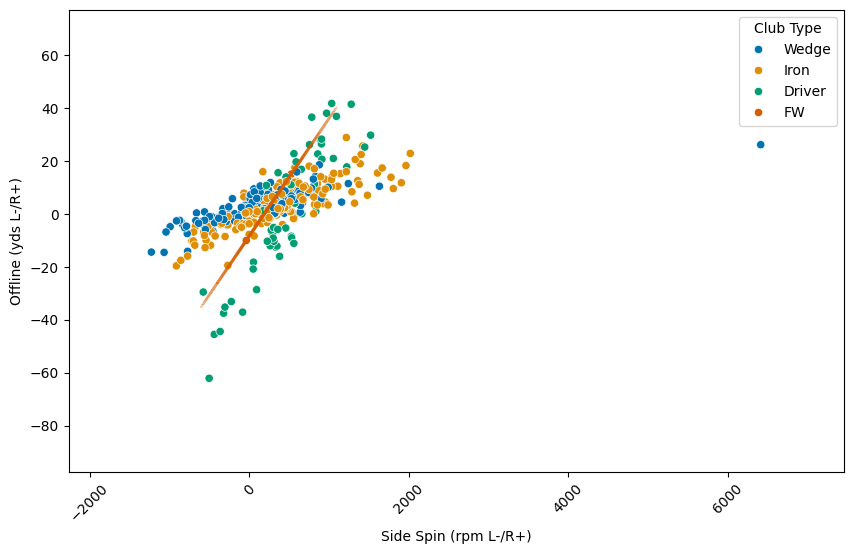

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(x='Side Spin (rpm L-/R+)', y='Offline (yds L-/R+)', data=data,palette='colorblind', hue='Club Type', alpha=0.6)
sns.scatterplot(x='Side Spin (rpm L-/R+)', y='Offline (yds L-/R+)', data=data,legend=True, hue='Club Type', palette='colorblind')
plt.title='Side Spin relation to Offline'
plt.xlabel('Side Spin (rpm L-/R+)')
plt.ylabel('Offline (yds L-/R+)')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Calculate efficiency (smash factor) summary
efficiency_summary = data.groupby('Club Name').agg({
    'Club Speed (mph)': ['mean', 'std'],
    'Ball Speed (mph)': ['mean', 'std'],
    'Carry (yds)': ['mean', 'std'],
    'Launch Angle (deg)': ['mean', 'std']

}).reset_index()

# Flatten the multi-level columns
efficiency_summary.columns = ['Club Name','Club Speed Mean', 'Club Speed Std',
                              'Ball Speed Mean', 'Ball Speed Std', 'Carry Mean',
                              'Carry Std','Launch Angle Mean', 'Launch Angle Std']
efficiency_summary
#efficiency_summary.to_csv("Metrics/Std_Mean_by_Club.csv",index=False)


,Club Name,Club Speed Mean,Club Speed Std,Ball Speed Mean,Ball Speed Std,Carry Mean,Carry Std,Launch Angle Mean,Launch Angle Std
0,3w,87.137931,3.267321,126.350000,4.737615,187.250000,4.596194,15.000000,8.343860
1,5h,87.776842,3.552334,109.721053,4.440418,157.063158,4.691862,17.821053,1.611272
2,6i,85.005000,2.762796,106.256250,3.453495,146.731250,7.074246,19.931250,1.363681
3,7i,80.681739,3.081252,100.852174,3.851565,134.641304,6.450860,21.795652,3.311526
4,8i,76.221176,3.559343,95.276471,4.449178,124.444118,8.361607,24.197059,2.021623
5,9i,70.260800,3.821035,87.826000,4.776294,109.914000,7.258521,27.518000,3.740058
6,Dr,86.783712,2.463352,134.514754,3.818195,212.442623,10.336158,14.578689,2.155931
7,GW,NaN,NaN,71.002128,4.386466,79.040426,7.582837,36.706383,5.383001
8,LW,NaN,NaN,51.433333,5.934082,46.800000,9.559812,40.766667,8.187999
9,PW,NaN,NaN,79.126087,3.748507,94.980435,7.147389,32.930435,2.943004


In [ ]:
data['Spin Efficiency'] = (data['Back Spin (rpm)'] + data['Side Spin (rpm L-/R+)']) / data['Ball Speed (mph)']

In [ ]:
data['Spin Efficiency']

,Spin Efficiency
0,77.044728
1,73.116531
2,65.411255
3,94.023845
4,79.391304
...,...
348,70.914634
349,26.742424
350,27.086438
351,36.773472


In [ ]:
# Save the updated DataFrame to a new CSV file
updated_file_path = 'updated_metrics_gulftee.csv'  # Update this path
data.to_csv(updated_file_path, index=False)
print(f"Updated CSV saved to {updated_file_path}")

Updated CSV saved to updated_metrics_gulftee.csv


## Train a model to predict club-path


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load data
url = "https://raw.githubusercontent.com/tim-blackmore/launch-monitor-regression/main/data.csv"
df = pd.read_csv(url)




In [ ]:
def clean_numeric_column(series):
    """Cleans unit-labeled strings and converts to float, returns unchanged if can't clean."""
    try:
        # Remove units and symbols
        cleaned = (
            series.astype(str)
            .str.replace(r'[^0-9.\-]', '', regex=True)  # Keep numbers, decimal, minus
            .replace('', pd.NA)
        )
        return pd.to_numeric(cleaned, errors='coerce')
    except Exception as e:
        return series  # Return original if cleaning not possible

# Apply only to object columns that are numeric-like
for col in df.columns:
    if df[col].dtype == 'object' and df[col].str.contains(r'\d', regex=True).any():
        df[col] = clean_numeric_column(df[col])




In [ ]:
features = [
    'Ball Speed', 'Club Speed', 'Launch Angle', 'Spin Rate', 'Smash Factor',
    'Attack Angle', 'Dyn. Loft', 'Curve'
]
targets = ['Club Path', 'Face To Path']

df_clean = df.dropna(subset=features + targets)
X = df_clean[features]
y = df_clean[targets]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
for i, target in enumerate(targets):
    print(f"=== {target.upper()} ===")
    print("R² Score:", r2_score(y_test.iloc[:, i], y_pred[:, i]))
    print("MSE:", mean_squared_error(y_test.iloc[:, i], y_pred[:, i]))
    print()


=== CLUB PATH ===
R² Score: 0.4730443981852642
MSE: 10.781807695617102

=== FACE TO PATH ===
R² Score: 0.7968233868825794
MSE: 8.866055266695827



In [ ]:
df_clean[['Launch Direction', 'Swing Direction']]

In [ ]:
X_train

In [ ]:
df.columns